## Data Collection and Cleaning

First we get a collection of the last years worth of player injuries

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

def nba_injuries(start_date="2022-01-01", end_date="2023-01-01", player="", team=""):
    try:
        player = player.replace(" ", "+")
        base_url = "https://www.prosportstransactions.com/basketball/Search/SearchResults.php"
        css_selector = ".datatable"
        start = 0
        all_pages_data = []

        while True:
            params = {
                "Player": player,
                "Team": team,
                "BeginDate": start_date,
                "EndDate": end_date,
                "ILChkBx": "yes",
                "InjuriesChkBx": "yes",
                "PersonalChkBx": "yes",
                "Submit": "Search",
                "start": start
            }

            response = requests.get(base_url, params=params)
            soup = BeautifulSoup(response.content, 'html.parser')
            table = soup.select_one(css_selector)

            if table:
                df = pd.read_html(str(table))[0]
                df.columns = df.iloc[0]  # Set the first row as column names
                df = df[1:]  # Remove the first row
                all_pages_data.append(df)

                # Check for the 'Next' link - if it doesn't exist, break the loop
                if not soup.find('a', text='Next'):
                    break

                start += 25  # Update start for next page
            else:
                break

        # Combine all pages data into one DataFrame
        if all_pages_data:
            final_df = pd.concat(all_pages_data, ignore_index=True)
            final_df['Date'] = pd.to_datetime(final_df['Date'])
            final_df['Acquired'] = final_df['Acquired'].str.replace("… ", "")
            final_df['Relinquished'] = final_df['Relinquished'].str.replace("… ", "")
            return final_df
        else:
            print("No data found for the given parameters.")
            return pd.DataFrame()  # Return empty DataFrame if no data found

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return empty DataFrame in case of error

# Example usage
df = nba_injuries()


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1372640742.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1372640742.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1372640742.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1372640742.py:32: FutureWarning: Passing literal html to 'read_html' is deprec

In [ ]:
df.to_csv('out.csv', index=False)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
current_date = pd.to_datetime('2023-01-01')

# Melt the DataFrame to unify 'Relinquished' and 'Acquired' under a single 'Player' column
latest_dates = df.melt(id_vars='Date', value_vars=['Relinquished', 'Acquired'], var_name='Status', value_name='Player')
latest_dates = latest_dates.dropna(subset=['Player']).sort_values(by='Date', ascending=False)
latest_dates = latest_dates.drop_duplicates(subset=['Player'], keep='first')

# Create a 'Got Injured' column: 1 if 'Relinquished', 0 if 'Acquired'
latest_dates['Got Injured'] = (latest_dates['Status'] == 'Relinquished').astype(int)

# Aggregate original data for players listed in 'Relinquished'
grouped_df = df.dropna(subset=['Relinquished']).groupby('Relinquished').agg({
    'Date': lambda x: (current_date - max(x)).days,
    'Notes': lambda x: list(x.dropna())
}).reset_index()

# Merge the aggregated data with the latest_dates to include the 'Got Injured' status
grouped_df = grouped_df.merge(latest_dates[['Player', 'Got Injured']], left_on='Relinquished', right_on='Player', how='left')

# Rename columns for clarity and avoid deleting necessary columns
grouped_df = grouped_df.rename(columns={'Relinquished': 'Player', 'Date': 'Days Since Last Injury', 'Notes': 'List of Past Injuries','Player':'DROP'})
grouped_df.drop(columns = ["DROP"],inplace = True)
grouped_df



In [ ]:
injury_types = ["core", "upper body", "ligament", "foot", "back"]

def filter_injury_types(injuries_list):
    """Filters a list of injuries to include only predefined injury types."""
    filtered_types = []
    for injury in injuries_list:
        for injury_type in injury_types:
            if injury_type in injury.lower():
                filtered_types.append(injury_type)
    return filtered_types

#grouped_df['Injury Types'] = grouped_df['List of Past Injuries'].apply(has_injury_type)

# Apply the function to filter and extract relevant injury types
grouped_df['Filtered Injuries'] = grouped_df['List of Past Injuries'].apply(filter_injury_types)

# Explode the list of filtered injuries into separate rows
exploded_df = grouped_df.explode('Filtered Injuries')

# Create dummy variables for each injury type
injury_dummies = pd.get_dummies(exploded_df['Filtered Injuries'])
grouped_df = grouped_df.join(injury_dummies.groupby(level=0).sum())

# Ensure all injury types are represented in the DataFrame
for injury_type in injury_types:
    if injury_type not in grouped_df.columns:
        grouped_df[injury_type] = 0

# Optionally, select only the injury type columns
grouped_df = grouped_df[['Player', 'Days Since Last Injury', 'Got Injured'] + injury_types]


# Display the updated DataFrame
print(grouped_df)

                   Player  Days Since Last Injury  core  upper body  ligament  \
0    • (Sean) Chris Smith                     284     0           0         0   
1            • A.J. Green                      64     0           0         0   
2          • Aaron Gordon                       5     0           0         0   
3         • Aaron Holiday                     310     0           0         0   
4         • Aaron Nesmith                       9     0           0         0   
..                    ...                     ...   ...         ...       ...   
483        • Zach Collins                     323     0           0         0   
484         • Zach LaVine                      65     0           0         0   
485          • Zeke Nnaji                      53     0           0         0   
486     • Ziaire Williams                      74     0           0         0   
487     • Zion Williamson                      10     0           0         0   

     foot  back  
0       0

In [ ]:
grouped_df['Player'] = grouped_df['Player'].str.replace('•', '')
grouped_df.head()

,Player,Days Since Last Injury,core,upper body,ligament,foot,back,Got Injured
0,(Sean) Chris Smith,284,0,0,0,0,0,0
1,A.J. Green,64,0,0,0,0,0,0
2,Aaron Gordon,5,0,0,0,1,0,0
3,Aaron Holiday,310,0,0,0,0,0,0
4,Aaron Nesmith,9,0,0,0,1,0,0


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def fetch_last_5_games_data(player_url):
    response = requests.get(player_url)
    if response.status_code != 200:
        print(f"Failed to retrieve the web page. Status code: {response.status_code}")
        return None

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the div containing the last 5 games data
    last5_div = soup.find('div', id='all_last5')
    if not last5_div:
        print("Last 5 games div not found.")
        return None

    # The table might be directly inside the div
    table = last5_div.find('table')
    if not table:
        print("Last 5 games table not found.")
        return None

    # Parse the table with pandas
    df = pd.read_html(str(table))[0]

    # Clean and process the DataFrame to have the desired columns

    df['GameLocation'] = df.apply(lambda row: row['Opp'].replace('@', '').strip()
                                  if '@' in row['Opp'] else row['Team'], axis=1)

    # Clean the 'MP' column, which represents minutes played
    df['MP'] = df['MP']

    # Select and rename the relevant columns
    relevant_data = df[['Date', 'MP', 'GameLocation']].rename(columns={
        'MP': 'TimePlayed'
    })

    return relevant_data

# Example usage
player_url = "https://www.basketball-reference.com/players/g/greenje02.html"
last_5_games_df = fetch_last_5_games_data(player_url)
print(last_5_games_df)



         Date  TimePlayed GameLocation
0  2024-04-14          12          HOU
1  2024-04-12          17          HOU
2  2024-04-11          22          HOU
3  2024-04-09          17          HOU
4  2024-04-07          17          HOU


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/3039416178.py:27: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [ ]:
import requests
from bs4 import BeautifulSoup

def search_for_player_page(player_name):
    # Encode the player's name for use in a URL
    query = player_name.replace(' ', '+')

    # The base URL for the basketball-reference search
    search_url = f'https://www.basketball-reference.com/search/search.fcgi?search={query}'

    # Perform the search request
    response = requests.get(search_url)

    # If the response URL is a player page, return it directly
    if 'players' in response.url:
        return response.url

    if response.status_code != 200:
        print(f"Failed to retrieve the search page. Status code: {response.status_code}")
        return None

    # Parse the search results page to find links
    soup = BeautifulSoup(response.content, 'html.parser')

    # Look for the div that contains the search results
    search_results = soup.find('div', id='players')

    if search_results:
        # Attempt to find an anchor element within the search results
        player_link = search_results.find('a')

        if player_link and 'href' in player_link.attrs:
            # Construct the full URL to the player's page
            player_page_url = 'https://www.basketball-reference.com' + player_link['href']
            return player_page_url
        else:
            print("No player link found in the search results.")
            return None
    else:
        print("No search results found for the player.")
        return None

# Example usage
player_name = "LeBron James"
player_page_url = search_for_player_page(player_name)
print(f"Player page URL: {player_page_url}")

Player page URL: https://www.basketball-reference.com/players/j/jamesle01.html


In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import re

def fetch_player_info(player_url):
    response = requests.get(player_url)
    if response.status_code != 200:
        return f"Failed to retrieve the web page. Status code: {response.status_code}"

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extracting the player's name from the <h1> tag
    player_name = soup.select_one('.players h1').text.strip() if soup.select_one('.players h1') else "Unknown"

    # Extracting the position, height, weight, and birth date from the player's meta information
    meta_info = soup.find('div', id='meta')

    # Position
    # Position
    position_tag = meta_info.find('strong', text=lambda x: x and 'Position:' in x)
    position = position_tag.next_sibling.strip() if position_tag and position_tag.next_sibling else "Unknown"


    # Height and Weight

    height_weight_text = meta_info.find('span', text=lambda x: x and 'lb' in x)
    height = height_weight_text.next_sibling.strip() if height_weight_text else "Unknown"
    weight = height_weight_text.text.strip() if height_weight_text else "Unknown"

    # Birth date for age calculation
    birth_date_tag = meta_info.find('span', id='necro-birth')
    birth_date_str = birth_date_tag['data-birth'] if birth_date_tag else "Unknown"

    if birth_date_str != "Unknown":
        birth_date = datetime.strptime(birth_date_str, '%Y-%m-%d').date()
        today = datetime.now().date()
        age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    else:
        age = "Unknown"

    # Weight
    weight_match = re.search(r"\d+", weight)
    weight = int(weight_match.group()) if weight_match else "Unknown"

    # Experience
    experience = meta_info.find('strong', text='Experience:').next_sibling.strip() if meta_info.find('strong', text='Experience:') else "Unknown"
    experience_match = re.search(r"\d+", experience)
    experience = int(experience_match.group()) if experience_match else "Unknown"

    player_data = {
        'Name': player_name,
        'Position': position.split(",")[0],
        'Height': int(re.search(r"(\d+)cm", height).group(1)),
        'Weight': weight,
        'Age': age,
        'Experience': experience
    }

    return player_data

# Example usage
player_url = "https://www.basketball-reference.com/players/j/jamesle01.html"
player_info = fetch_player_info(player_url)
print(player_info)
print(type(player_info))


{'Name': 'LeBron James', 'Position': 'Small Forward', 'Height': 206, 'Weight': 250, 'Age': 39, 'Experience': 20}
<class 'dict'>


In [ ]:
import time
import pandas as pd

basic_info = pd.DataFrame(columns=['Name', 'Position', 'Height', 'Weight', 'Age', 'Experience'])
last_five_games = pd.DataFrame(columns=['Name', 'Last_5_Games'])

# Default values for last 5 games, assuming you expect 5 entries
default_game_data = [None] * 5  # Replace None with a more appropriate default if needed

for name in grouped_df["Player"]:
    time.sleep(10)
    print(f"Processing {name}")
    my_url = search_for_player_page(name)
    if not my_url:
        continue
    my_basic_info = fetch_player_info(my_url)
    my_five_games = fetch_last_5_games_data(my_url)

    # If data is fetched, use it, otherwise stick with defaults
    actual_game_data = list(my_five_games["TimePlayed"]) if my_five_games is not None else default_game_data

    # Ensure the list is always of length 5
    actual_game_data = actual_game_data[:5] + [None] * (5 - len(actual_game_data))

    # Dictionary for DataFrame
    # Proposed addendum: five_games_df = {"Name": [name], "Last_5_Games": [actual_game_data], "Location of Games": [my_five_games["Location"]]}
    five_games_df = {"Name": [name], "Last_5_Games": [actual_game_data]}
    my_basic_info = {key: [value] for key, value in my_basic_info.items()}

    # Create and append to DataFrame as before
    basic_info = pd.concat([basic_info, pd.DataFrame(my_basic_info)], ignore_index=True)
    last_five_games = pd.concat([last_five_games, pd.DataFrame(five_games_df)], ignore_index=True)

# Save DataFrames to CSV
basic_info.to_csv("basic_info.csv", encoding='utf-8', index=False)
last_five_games.to_csv("last_five_games.csv", encoding='utf-8', index=False)


In [ ]:
basic_info = pd.read_csv("basic_info.csv") # run if you accidentally  closed the editor lol
last_5_games_df = pd.read_csv("last_five_games.csv")
basic_info

,Name,Position,Height,Weight,Age,Experience
0,A.J. Green,Shooting Guard\n\n\n \n ▪,193,200,24,1
1,Aaron Gordon,Power Forward and Small Forward\n\n\n \n ▪,203,235,28,9
2,Aaron Holiday,Point Guard\n\n\n \n ▪,183,185,27,5
3,Aaron Nesmith,Small Forward\n\n\n \n ▪,196,215,24,3
4,Aaron Wiggins,Shooting Guard\n\n\n \n ▪,198,200,25,2
...,...,...,...,...,...,...
448,Zach Collins,Center and Power Forward\n\n\n \n ▪,211,250,26,5
449,Zach LaVine,Shooting Guard,196,200,29,9
450,Zeke Nnaji,Power Forward\n\n\n \n ▪,206,240,23,3
451,Ziaire Williams,Small Forward\n\n\n \n ▪,206,215,22,2


In [ ]:
# Filtering based on position
positions = ['Point Guard', 'Shooting Guard', 'Power Forward', 'Small Forward', 'Center']

# Normalize and clean the position strings
basic_info['Position'] = basic_info['Position'].str.replace(r'[^a-zA-Z\n ]', '', regex=True).str.split('\n').apply(lambda x: [pos.strip() for pos in x if pos.strip()])

# Explode the 'Position' into separate rows for each position type
position_df = basic_info.explode('Position')

# Get dummy variables for each position
position_dummies = pd.get_dummies(position_df['Position'])

# Group by original index and sum the dummies to avoid duplicates within the same player
position_dummies = position_dummies.groupby(position_df.index).sum()

# Join the dummy variables back to the original DataFrame
basic_info = basic_info.join(position_dummies)

# Ensure all specified positions are represented in the DataFrame, filling missing with 0
for position in positions:
    if position not in basic_info.columns:
        basic_info[position] = 0


In [ ]:
grouped_df

,Player,Days Since Last Injury,core,upper body,ligament,foot,back,Got Injured
0,(Sean) Chris Smith,284,0,0,0,0,0,0
1,A.J. Green,64,0,0,0,0,0,0
2,Aaron Gordon,5,0,0,0,1,0,0
3,Aaron Holiday,310,0,0,0,0,0,0
4,Aaron Nesmith,9,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
483,Zach Collins,323,0,0,0,0,0,0
484,Zach LaVine,65,0,0,0,0,1,0
485,Zeke Nnaji,53,0,0,0,0,0,0
486,Ziaire Williams,74,0,0,0,0,0,0


In [ ]:
# Run this if you are importing from the csv
import ast
past_games_data_temp = last_5_games_df.copy()

past_games_data_temp['Last_5_Games'] = past_games_data_temp['Last_5_Games'].apply(ast.literal_eval)

# Expand the lists into separate columns
past_games_data_temp[['Game_1', 'Game_2', 'Game_3', 'Game_4', 'Game_5']] = pd.DataFrame(past_games_data_temp['Last_5_Games'].tolist(), index=past_games_data_temp.index)

# Optionally drop the original 'Last_5_Games' column
past_games_data_temp.drop('Last_5_Games', axis=1, inplace=True)

In [ ]:
!pip install numpy==1.21.4
!pip install threadpoolctl==3.1.0

     |████████████████████████████████| 17.0 MB 2.5 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
torchtext 0.17.2 requires torch==2.2.2, but you have torch 2.2.1 which is incompatible.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.21.4 which is incompatible.
scipy 1.13.0 requires numpy<2.3,>=1.22.4, but you have numpy 1.21.4 which is incompatible.
pandas 2.2.2 requires numpy>=1.22.4; python_version < "3.11", but you have numpy 1.21.4 which is incompatible.
onnxruntime 1.16.3 requires numpy>=1.21.6, but you have numpy 1.21.4 which is incompatible.
  Attempting uninstall: threadpoolctl
    Found existing in

In [ ]:
#!export OPENBLAS_NUM_THREADS=1
!pip install -U threadpoolctl

  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0


In [ ]:
# Preprocessing data
import torch
import ast
from torch import nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN




grouped_df['Player'] = grouped_df['Player'].str.upper().str.strip()
basic_info['Name'] = basic_info['Name'].str.upper().str.strip()

filtered_grouped_df = grouped_df[grouped_df['Player'].isin(basic_info['Name'])]
current_game_player_data = basic_info.copy()
past_injuries_data_temp = filtered_grouped_df.copy()
past_games_data_temp = last_5_games_df.copy()

past_games_data_temp['Last_5_Games'] = past_games_data_temp['Last_5_Games'].apply(ast.literal_eval)

# Expand the lists into separate columns
past_games_data_temp[['Game_1', 'Game_2', 'Game_3', 'Game_4', 'Game_5']] = pd.DataFrame(past_games_data_temp['Last_5_Games'].tolist(), index=past_games_data_temp.index)

# Optionally drop the original 'Last_5_Games' column
past_games_data_temp.drop('Last_5_Games', axis=1, inplace=True)

past_games_data = past_games_data_temp
past_injuries_data = past_injuries_data_temp.drop('Got Injured', axis=1)  # Drop the label column to create features
#past_injuries_data.drop('List of Past Injuries', axis = 1, inplace= True)
labels = past_injuries_data_temp['Got Injured']  # Isolate the label column

past_games_data.drop('Name', axis =1, inplace=True)
if past_games_data_temp.isnull().any().any():
    past_games_data_temp.fillna(0, inplace=True)  # Or another appropriate fill value

past_injuries_data.drop('Player', axis =1, inplace = True)
current_game_player_data.drop('Name', axis =1, inplace =True)
current_game_player_data.drop('Position', axis =1, inplace =True)
# Convert 'Age' and 'Experience' to numeric types, coercing errors to NaN (or a default value)
current_game_player_data['Age'] = pd.to_numeric(current_game_player_data['Age'], errors='coerce')
current_game_player_data['Experience'] = pd.to_numeric(current_game_player_data['Experience'], errors='coerce')

# Optionally fill NaNs with a default value, such as 0 or the mean/median of the column
current_game_player_data['Age'].fillna(0, inplace=True)
current_game_player_data['Experience'].fillna(0, inplace=True)

# Convert to integer if that is more appropriate
current_game_player_data['Age'] = current_game_player_data['Age'].astype(int)
current_game_player_data['Experience'] = current_game_player_data['Experience'].astype(int)


# Convert DataFrames/Series to tensors
past_injuries_tensor = torch.tensor(past_injuries_data.values, dtype=torch.float32)
past_games_tensor = torch.tensor(past_games_data.values, dtype=torch.float32)
current_game_player_tensor = torch.tensor(current_game_player_data.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.long)  # Assuming labels are categorical for CrossEntropyLoss

# Split the data into training and testing sets
train_idx, test_idx = train_test_split(
    range(len(labels_tensor)),
    test_size=0.2,
    stratify=labels_tensor
)

# Creating training and testing datasets using indices
train_dataset = TensorDataset(
    past_injuries_tensor[train_idx],
    past_games_tensor[train_idx],
    current_game_player_tensor[train_idx],
    labels_tensor[train_idx]
)

test_dataset = TensorDataset(
    past_injuries_tensor[test_idx],
    past_games_tensor[test_idx],
    current_game_player_tensor[test_idx],
    labels_tensor[test_idx]
)

def manual_oversample(features_tensors, labels_tensor):
    # Convert tensors to numpy arrays for easier manipulation
    features_np = [tensor.numpy() for tensor in features_tensors]
    labels_np = labels_tensor.numpy()

    # Find the unique classes and their counts
    classes, counts = np.unique(labels_np, return_counts=True)
    max_count = np.max(counts)

    # Determine the indices to replicate for each class to balance the dataset
    resampled_features = [list() for _ in features_tensors]  # Use lists to collect arrays
    resampled_labels = []

    for cls in classes:
        cls_indices = np.where(labels_np == cls)[0]
        oversample_indices = np.random.choice(cls_indices, size=max_count, replace=True)
        resampled_labels.extend(labels_np[oversample_indices])
        for i, feature_set in enumerate(features_np):
            resampled_features[i].extend(feature_set[oversample_indices])

    # Convert list of arrays into correctly shaped numpy arrays and then to tensors
    resampled_features_tensors = [torch.tensor(np.array(feature), dtype=torch.float32) for feature in resampled_features]
    resampled_labels_tensor = torch.tensor(resampled_labels, dtype=torch.long)

    return resampled_features_tensors, resampled_labels_tensor

# Apply manual oversampling to the training data
resampled_features_tensors, resampled_labels_tensor = manual_oversample(
    [past_injuries_tensor[train_idx], past_games_tensor[train_idx], current_game_player_tensor[train_idx]],
    labels_tensor[train_idx]
)

# Create the new balanced training dataset
balanced_train_dataset = TensorDataset(
    *resampled_features_tensors,  # Unpack the list of tensors
    resampled_labels_tensor
)


# Use the resampled tensors to create the TensorDataset
#train_dataset_resampled = TensorDataset(X_train_resampled_tensor, y_train_resampled_tensor)




/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/2724957994.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  current_game_player_data['Age'].fillna(0, inplace=True)
/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/2724957994.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [ ]:
# Defining models and helper functions
# Define DataLoader
batch_size = 64
train_loader = DataLoader(balanced_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class TransformerModel_PI(nn.Module):
    def __init__(self):
        super(TransformerModel_PI, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=3,dropout = 0.1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.init_weights()

    def forward(self, src):
        src = self.encoder_layer(src)
        if torch.isnan(src).any():
            print("NaNs detected after encoder layer")
        encoded = self.transformer_encoder(src)
        if torch.isnan(encoded).any():
            print("NaNs detected after transformer encoder")
        output = encoded.mean(dim=1, keepdim=True)
        if torch.isnan(output).any():
            print("NaNs detected after mean pooling")
        return output
        #encoded = self.transformer_encoder(src)
        #return encoded.mean(dim=1, keepdim=True)  # average pooling

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class TransformerModel_PG(nn.Module):
    def __init__(self):
        super(TransformerModel_PG, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=5, nhead=5,dropout = 0.1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.init_weights()

    def forward(self, src):
        src = self.encoder_layer(src)
        if torch.isnan(src).any():
            print("NaNs detected after encoder layer")
        encoded = self.transformer_encoder(src)
        if torch.isnan(encoded).any():
            print("NaNs detected after transformer encoder")
        output = encoded.mean(dim=1, keepdim=True)
        if torch.isnan(output).any():
            print("NaNs detected after mean pooling")
        return output
        #encoded = self.transformer_encoder(src)
        #return encoded.mean(dim=1, keepdim=True)  # average pooling

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Binary classification
        self.init_weights()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def ensure_2d(tensor):
    """ Ensure tensor is 2D, adding a batch dimension if necessary. """
    if tensor.dim() == 1:
        tensor = tensor.unsqueeze(0)  # Add a batch dimension if missing
    return tensor

In [ ]:
# Training and testing loop
# Important for unbalanced data
#classes = np.unique(labels)
#class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
#class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Initialize the loss function with these weights
#criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
criterion = nn.CrossEntropyLoss()
past_injuries_transformer = TransformerModel_PI()
past_games_transformer = TransformerModel_PG()
mlp = MultilayerPerceptron(input_dim= 21)

parameters = list(past_injuries_transformer.parameters()) + list(past_games_transformer.parameters()) + list(mlp.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

num_epochs = 50  # Define number of epochs
for epoch in range(num_epochs):
    past_injuries_transformer.train()
    past_games_transformer.train()
    mlp.train()

    for past_injuries, past_games, current_game_player, label in train_loader:
        past_injuries = ensure_2d(past_injuries)
        past_games = ensure_2d(past_games)
        current_game_player = ensure_2d(current_game_player)
        optimizer.zero_grad()
        past_injuries_encoded = past_injuries_transformer(past_injuries)
        past_games_encoded = past_games_transformer(past_games)

        combined_features = torch.cat((past_injuries_encoded, past_games_encoded, current_game_player), dim=1)
        outputs = mlp(combined_features)
        loss = criterion(outputs, label)
        if torch.isnan(loss):
            print("NaN detected in loss, stopping training")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters, max_norm=1.0)
        optimizer.step()

    if torch.isnan(loss):
        print(f"Stopped at Epoch {epoch+1} due to NaN in loss")
        break
    # Testing phase
    past_injuries_transformer.eval()
    past_games_transformer.eval()
    mlp.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for past_injuries, past_games, current_game_player, label in test_loader:
            past_injuries = ensure_2d(past_injuries)
            past_games = ensure_2d(past_games)
            current_game_player = ensure_2d(current_game_player)
            past_injuries_encoded = past_injuries_transformer(past_injuries)
            past_games_encoded = past_games_transformer(past_games)

            combined_features = torch.cat((past_injuries_encoded, past_games_encoded, current_game_player), dim=1)
            outputs = mlp(combined_features)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.2f}%')

Epoch [1/50], Loss: 3.7309, Test Accuracy: 3.45%
Epoch [2/50], Loss: 0.9202, Test Accuracy: 96.55%
Epoch [3/50], Loss: 1.9127, Test Accuracy: 96.55%
Epoch [4/50], Loss: 1.4568, Test Accuracy: 6.90%
Epoch [5/50], Loss: 2.1527, Test Accuracy: 96.55%
Epoch [6/50], Loss: 1.1132, Test Accuracy: 13.79%
Epoch [7/50], Loss: 1.1063, Test Accuracy: 39.08%
Epoch [8/50], Loss: 3.1790, Test Accuracy: 96.55%
Epoch [9/50], Loss: 1.9449, Test Accuracy: 3.45%
Epoch [10/50], Loss: 0.7054, Test Accuracy: 96.55%
Epoch [11/50], Loss: 2.2744, Test Accuracy: 94.25%
Epoch [12/50], Loss: 1.4103, Test Accuracy: 4.60%
Epoch [13/50], Loss: 1.1504, Test Accuracy: 96.55%
Epoch [14/50], Loss: 1.2480, Test Accuracy: 31.03%
Epoch [15/50], Loss: 2.4917, Test Accuracy: 96.55%
Epoch [16/50], Loss: 1.5838, Test Accuracy: 96.55%
Epoch [17/50], Loss: 0.4798, Test Accuracy: 96.55%
Epoch [18/50], Loss: 0.5013, Test Accuracy: 65.52%
Epoch [19/50], Loss: 3.7648, Test Accuracy: 96.55%
Epoch [20/50], Loss: 0.8537, Test Accuracy: 

In [ ]:
print(predicted)
print(label)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])


# RNN

In [ ]:
# Load datasets
basic_info_df = pd.read_csv('basic_info.csv')
injury_data_df = pd.read_csv('Injury_Data.csv')
last_five_games_df = pd.read_csv('last_five_games.csv')
merged_new_df = pd.read_csv('merged.csv')

# Clean and standardize names for merging
def standardize_names(name):
    return name.lower().replace('.', '').replace("'", '').strip()

basic_info_df['Name'] = basic_info_df['Name'].apply(standardize_names)
injury_data_df['Player'] = injury_data_df['Player'].apply(standardize_names)
last_five_games_df['Name'] = last_five_games_df['Name'].apply(standardize_names)
merged_new_df['PLAYER_NAME'] = merged_new_df['PLAYER_NAME'].apply(standardize_names)

# Merge all datasets
full_merged_df = pd.merge(basic_info_df, last_five_games_df, on='Name', how='left')
full_merged_df = pd.merge(full_merged_df, injury_data_df, left_on='Name', right_on='Player', how='left')
full_merged_df = pd.merge(full_merged_df, merged_new_df, left_on='Name', right_on='PLAYER_NAME', how='left')


In [ ]:
# ensure days missed is an integer
full_merged_df['DAYS MISSED'] = full_merged_df['DAYS MISSED'].astype(int)

# print days missed
print(full_merged_df['DAYS MISSED'])


0        4
1        5
2        4
3       38
4        4
        ..
2593     1
2594     6
2595     4
2596     4
2597     3
Name: DAYS MISSED, Length: 2598, dtype: int64


In [ ]:
print(full_merged_df.head())

           Name                                      Position  Height  Weight  \
0      aj green                   Shooting Guard\n\n\n  \n  ▪     193     200   
1  aaron gordon  Power Forward and Small Forward\n\n\n  \n  ▪     203     235   
2  aaron gordon  Power Forward and Small Forward\n\n\n  \n  ▪     203     235   
3  aaron gordon  Power Forward and Small Forward\n\n\n  \n  ▪     203     235   
4  aaron gordon  Power Forward and Small Forward\n\n\n  \n  ▪     203     235   

  Age Experience          Last_5_Games  Unnamed: 0        Player  \
0  24          1    [5, 5, 21, 14, 15]         1.0      aj green   
1  28          9  [46, 42, 41, 40, 32]         2.0  aaron gordon   
2  28          9  [46, 42, 41, 40, 32]         2.0  aaron gordon   
3  28          9  [46, 42, 41, 40, 32]         2.0  aaron gordon   
4  28          9  [46, 42, 41, 40, 32]         2.0  aaron gordon   

   Days Since Last Injury  ...  AVG_SEC_PER_TOUCH  AVG_DRIB_PER_TOUCH  \
0                    64.0  ... 

In [ ]:
# print columns names
print(full_merged_df.columns)

# missing values
missing_values = full_merged_df.isnull().sum()
print(missing_values)

Index(['Name', 'Position', 'Height', 'Weight', 'Age', 'Experience',
       'Last_5_Games', 'Unnamed: 0', 'Player', 'Days Since Last Injury',
       'Got Injured', 'core', 'upper body', 'ligament', 'foot', 'back',
       'PLAYER_ID', 'PLAYER_NAME', 'SEASON', 'SEASON_NUM', 'AGE',
       'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'GP', 'MIN', 'USG_PCT', 'PACE',
       'POSS', 'FGA_PG', 'DRIVES', 'DRIVE_FGA', 'DRIVE_PASSES', 'DIST_MILES',
       'AVG_SPEED', 'PULL_UP_FGA', 'PULL_UP_FG3A', 'TOUCHES',
       'FRONT_CT_TOUCHES', 'AVG_SEC_PER_TOUCH', 'AVG_DRIB_PER_TOUCH',
       'ELBOW_TOUCHES', 'POST_TOUCHES', 'PAINT_TOUCHES', 'TEAM', 'INJURED ON',
       'RETURNED', 'DAYS MISSED', 'INJURED_TYPE'],
      dtype='object')
Name                         0
Position                     0
Height                       0
Weight                       0
Age                          0
Experience                   0
Last_5_Games                20
Unnamed: 0                  20
Player                      20


In [ ]:
# Clean 'Position' to keep only meaningful text
full_merged_df['Position'] = full_merged_df['Position'].str.extract(r'([a-zA-Z\s]+)')[0].str.strip()

# Handle missing values in numeric columns
numeric_cols = full_merged_df.select_dtypes(include=['float64', 'int64']).columns
full_merged_df[numeric_cols] = full_merged_df[numeric_cols].apply(lambda x: x.fillna(x.median()), axis=0)

# Convert 'Last_5_Games' from string of lists to actual lists
full_merged_df['Last_5_Games'] = full_merged_df['Last_5_Games'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [np.nan]*5)
last_games_features = ['game_{}'.format(i) for i in range(5)]
full_merged_df[last_games_features] = pd.DataFrame(full_merged_df['Last_5_Games'].tolist(), index=full_merged_df.index)
full_merged_df.drop('Last_5_Games', axis=1, inplace=True)

# Drop columns with high missing values and those not necessary for the model
cols_to_drop = ['Unnamed: 0', 'TEAM', 'INJURED ON', 'RETURNED', 'INJURED_TYPE']
full_merged_df.drop(columns=cols_to_drop, inplace=True)

# Handle missing values in categorical columns
categorical_cols = full_merged_df.select_dtypes(include=['object']).columns
full_merged_df[categorical_cols] = full_merged_df[categorical_cols].fillna('Unknown')


In [ ]:
# Convert 'DAYS MISSED' to integer
full_merged_df['DAYS MISSED'] = pd.to_numeric(full_merged_df['DAYS MISSED'], errors='coerce').fillna(0).astype(int)

# Check if 'DAYS MISSED' is in the DataFrame
if 'DAYS MISSED' not in full_merged_df.columns:
    raise ValueError("DAYS MISSED column is missing from the DataFrame.")


In [ ]:
# ensure days missed is an integer
full_merged_df['DAYS MISSED'] = full_merged_df['DAYS MISSED'].astype(int)

# print days missed
print(full_merged_df['DAYS MISSED'])


0        4
1        5
2        4
3       38
4        4
        ..
2593     1
2594     6
2595     4
2596     4
2597     3
Name: DAYS MISSED, Length: 2598, dtype: int64


In [ ]:
# Select numeric and categorical features
numeric_features = full_merged_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = full_merged_df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from features if present
if 'DAYS MISSED' in numeric_features:
    numeric_features.remove('DAYS MISSED')

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    ])

# Prepare X and y for the model
X = preprocessor.fit_transform(full_merged_df.drop('DAYS MISSED', axis=1))
y = full_merged_df['DAYS MISSED'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)  # Try a smaller value like 0.0001 or 0.00001
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])


# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model
performance = model.evaluate(X_val, y_val, verbose=1)
print(f'Test Loss: {performance[0]}, Test MAE: {performance[1]}')


Epoch 1/50


/Users/sparshkabra/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: n

In [ ]:
# Example to check for NaNs or Infs in your dataset
print(np.any(np.isnan(X_train)), np.any(np.isnan(y_train)))
print(np.any(np.isinf(X_train)), np.any(np.isinf(y_train)))

# If True, consider applying imputation or removing problematic data points


True False
False False


In [ ]:
from sklearn.impute import SimpleImputer

# Imputing NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

# Confirm no more NaNs
print(np.any(np.isnan(X_train)), np.any(np.isnan(X_val)))


False False


In [ ]:
# Rebuilding the model (if needed)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Recompile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Retrain the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model again
performance = model.evaluate(X_val, y_val)
print(f'Test Loss: {performance[0]}, Test MAE: {performance[1]}')


Epoch 1/50


/Users/sparshkabra/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 122.3176 - mean_absolute_error: 4.7551 - val_loss: 38.9252 - val_mean_absolute_error: 2.4258
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.5023 - mean_absolute_error: 2.5407 - val_loss: 38.2594 - val_mean_absolute_error: 2.5177
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56.5813 - mean_absolute_error: 2.6516 - val_loss: 38.3255 - val_mean_absolute_error: 2.5171
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.1430 - mean_absolute_error: 2.7284 - val_loss: 38.6096 - val_mean_absolute_error: 2.6758
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55.0007 - mean_absolute_error: 2.5771 - val_loss: 39.0968 - val_mean_absolute_error: 2.7893
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.3608 - mean_absolute_error: 2.5573 - val_loss: 40.4690 - val_mean_absolute_error: 3.0802
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66.6127 - mean_absolute_error: 2.7731 - val_loss: 41

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Modify the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model with a potentially lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_mean_absolute_error', patience=50, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# Evaluate the model
performance = model.evaluate(X_val, y_val)
print(f'Test Loss: {performance[0]}, Test MAE: {performance[1]}')

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 88.0003 - mean_absolute_error: 4.7860 - val_loss: 43.9866 - val_mean_absolute_error: 2.7186
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87.0368 - mean_absolute_error: 2.8595 - val_loss: 38.9708 - val_mean_absolute_error: 2.3963
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74.7392 - mean_absolute_error: 2.7356 - val_loss: 38.1996 - val_mean_absolute_error: 2.4480
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.6390 - mean_absolute_error: 2.7682 - val_loss: 38.3690 - val_mean_absolute_error: 2.4753
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102.8892 - mean_absolute_error: 2.9490 - val_loss: 38.7447 - val_mean_absolute_error: 2.6005
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63.7760 - mean_absolute_error: 2.6089 - val_loss: 39.2506 - val_mean_absolute_error: 2.8065
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.0665 - mean_absolute_error: 2.7482 - v

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the model architecture with L2 regularization
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(1)
])

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_mean_absolute_error', patience=20, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping], verbose=1)

# Evaluate the model
performance = model.evaluate(X_val, y_val)
print(f'Test Loss: {performance[0]}, Test MAE: {performance[1]}')


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 115.5340 - mean_absolute_error: 5.2711 - val_loss: 59.3869 - val_mean_absolute_error: 4.6900 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.8653 - mean_absolute_error: 4.8833 - val_loss: 55.0114 - val_mean_absolute_error: 4.1950 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.7795 - mean_absolute_error: 4.2288 - val_loss: 51.4385 - val_mean_absolute_error: 3.7781 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.2109 - mean_absolute_error: 3.6674 - val_loss: 47.8241 - val_mean_absolute_error: 3.2799 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.5396 - mean_absolute_error: 3.5438 - val_loss: 45.3658 - val_mean_absolute_error: 2.9808 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104.8262 - mean_absolute_error: 3.4343 - val_loss: 44.2692 - val

Epoch 1/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 99.8520 - mean_absolute_error: 4.1050 - val_loss: 39.8446 - val_mean_absolute_error: 2.4515 - learning_rate: 0.0010
Epoch 2/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.2706 - mean_absolute_error: 2.4994 - val_loss: 39.6262 - val_mean_absolute_error: 2.5383 - learning_rate: 0.0010
Epoch 3/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81.8420 - mean_absolute_error: 2.8849 - val_loss: 40.3194 - val_mean_absolute_error: 2.5590 - learning_rate: 0.0010
Epoch 4/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63.5527 - mean_absolute_error: 2.6571 - val_loss: 40.7930 - val_mean_absolute_error: 2.7043 - learning_rate: 0.0010
Epoch 5/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.3652 - mean_absolute_error: 2.5368 - val_loss: 41.3896 - val_mean_absolute_error: 2.8284 - learning_rate: 0.0010
Epoch 6/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.9300 - mean_absolute_error: 2.6488 - val_loss: 42.2748 - val_me

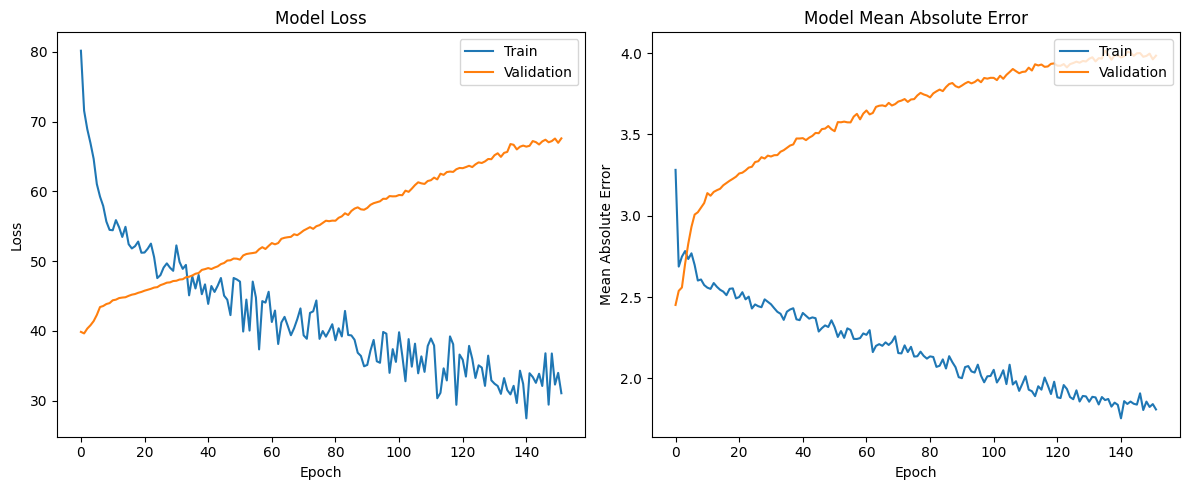

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model configuration
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Fit the model
history = model.fit(X_train, y_train, epochs=150, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


Epoch 1/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 143.8416 - mean_absolute_error: 5.3960 - val_loss: 61.4519 - val_mean_absolute_error: 4.8398 - learning_rate: 1.0000e-04
Epoch 2/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.7073 - mean_absolute_error: 4.6236 - val_loss: 57.9432 - val_mean_absolute_error: 4.4725 - learning_rate: 1.0000e-04
Epoch 3/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.2557 - mean_absolute_error: 4.1085 - val_loss: 53.8912 - val_mean_absolute_error: 4.0022 - learning_rate: 1.0000e-04
Epoch 4/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82.6697 - mean_absolute_error: 3.9336 - val_loss: 49.8103 - val_mean_absolute_error: 3.4681 - learning_rate: 1.0000e-04
Epoch 5/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 105.0234 - mean_absolute_error: 3.5341 - val_loss: 46.1143 - val_mean_absolute_error: 2.9322 - learning_rate: 1.0000e-04
Epoch 6/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.3663 - mean_absolute_error: 2.7550 - val_

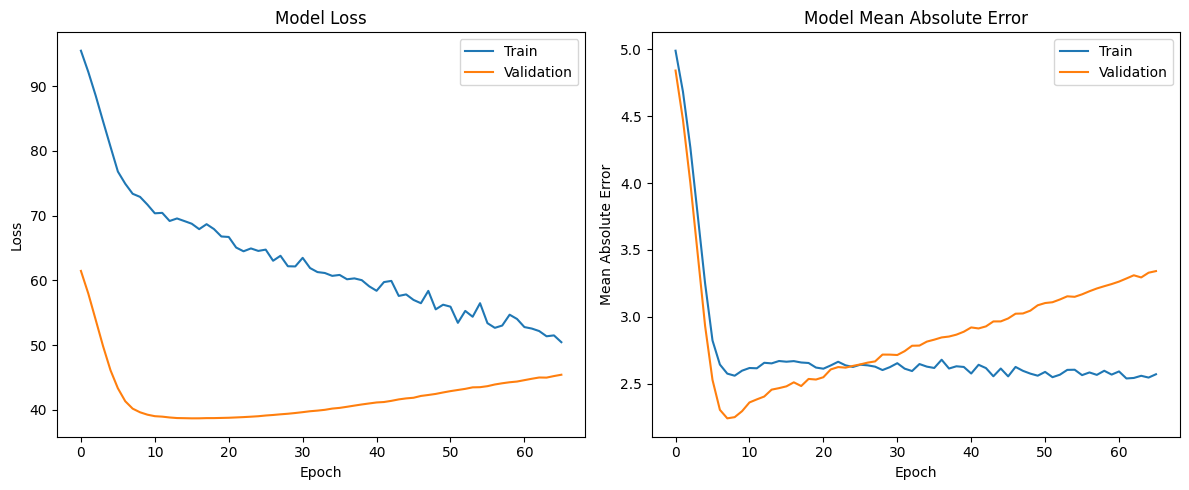

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Adjusting the model architecture
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

# Fit the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


Epoch 1/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 80.4887 - mean_absolute_error: 5.0584 - val_loss: 63.0749 - val_mean_absolute_error: 4.8677 - learning_rate: 1.0000e-04
Epoch 2/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131.2857 - mean_absolute_error: 5.0139 - val_loss: 58.9081 - val_mean_absolute_error: 4.4397 - learning_rate: 1.0000e-04
Epoch 3/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 88.4996 - mean_absolute_error: 4.2354 - val_loss: 53.8565 - val_mean_absolute_error: 3.8522 - learning_rate: 1.0000e-04
Epoch 4/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.2600 - mean_absolute_error: 3.9900 - val_loss: 48.6148 - val_mean_absolute_error: 3.1586 - learning_rate: 1.0000e-04
Epoch 5/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 77.6796 - mean_absolute_error: 3.0586 - val_loss: 44.3777 - val_mean_absolute_error: 2.5414 - learning_rate: 1.0000e-04
Epoch 6/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.3135 - mean_absolute_error: 2.6681 - val_

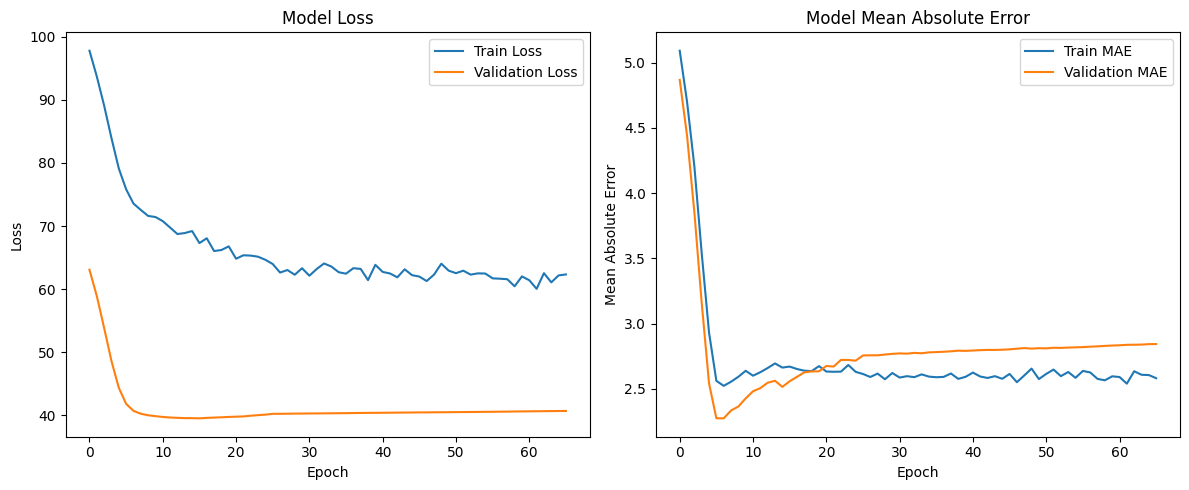

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Adjusting the model architecture with optimized layers and dropout
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.4),  # Increased dropout for better regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(1)
])

# Compile the model with an appropriate optimizer and loss function
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Setup callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Plotting the training & validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# print merged csv

df1 = pd.read_csv('merged.csv')
print(df1.head())

   PLAYER_ID    PLAYER_NAME SEASON  SEASON_NUM   AGE PLAYER_HEIGHT_INCHES  \
0    1630639    A.J. Lawson  22-23        22.5  22.0                   78   
1    1631260       AJ Green  22-23        22.5  23.0                   77   
2    1631100     AJ Griffin  22-23        22.5  19.0                   78   
3     203932   Aaron Gordon  22-23        22.5  27.0                   80   
4    1628988  Aaron Holiday  22-23        22.5  26.0                   72   

  PLAYER_WEIGHT  GP   MIN  USG_PCT  ...  AVG_SEC_PER_TOUCH  \
0           179  13   4.8    0.182  ...               1.39   
1           190  32   9.4    0.160  ...               2.61   
2           220  66  19.4    0.174  ...               2.08   
3           235  61  30.1    0.206  ...               2.94   
4           185  57  13.7    0.128  ...               4.17   

   AVG_DRIB_PER_TOUCH  ELBOW_TOUCHES  POST_TOUCHES  PAINT_TOUCHES     TEAM  \
0                0.62            0.0           0.0            0.2      NaN   
1       